<a href="https://colab.research.google.com/github/UnitForDataScience/DS_Tools_for-LiteraryAnalysis/blob/main/Intro_to_Sentiment_Analysis_and_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# “To code or not to code?”: How data science tools can enhance your literary analysis

An Open Lab by the UDS

---
This Colab notebook will give you a short introduction to Sentiment Analysis and Topic Modeling using R. These basic examples are meant to help you see how useful these methods might be to enhance your literary work. You can follow along the examples here or you can download this notebook and run the code in R Studio if you so desire.

### Let's begin by Installing some libraries
Libraries are free-to-use resources that will provide R with extra functionalities. We usually want to install them all upfront; each one of the libraries we are installing in the cell below will be used at some point in this notebook. Installing them might take some time in Colab, but it will be worth it. The comments (in green) are there to give you an idea of what each library brings to our codes.

In [ ]:
# Installing neccesary packages:

system("apt install libgsl-dev", intern=TRUE) # Required system library for advanced math functions
install.packages("reshape2") # Reshape data between wide and long formats

## Libraries for text Analysis:
install.packages("tidytext")# Text analysis tools that make text data easy to work with (convert text into tokenized forms and analyze it in a data frame format)
install.packages("tidyr") # Tools to organize data into a clean and usable format
install.packages("syuzhet")# Tools to analyze and extract sentiment and emotion from text. It includes several sentiment dictionaries.
install.packages("dplyr") # Data manipulation package for filtering, selecting, and summarizing data
install.packages("stringr") # Set of functions to work with text data in R, such as finding, matching, and replacing strings.
install.packages("tm") # Basic text mining package for processing and analyzing text data
install.packages("topicmodels") # A package for fitting topic models, such as Latent Dirichlet Allocation (LDA), to identify underlying themes in a corpus of text

## Text libraries
install.packages("gutenbergr") # Access texts in the public domain from Project Gutenberg
install.packages("janeaustenr") # Access Jane Austen's novels as data for easy analysis

##Data Visualization
install.packages("ggplot2") # Data visualization package for creating graphs and charts

Now that our packages have been installed, we need to load them as libraries for R to use. We will use a variety of functions in the following codes, so we might as well load them all now.

In [ ]:
# Load libraries
library(reshape2)

library(tidytext)
library(tidyr)
library(syuzhet)
library(dplyr)
library(stringr)
library(tm)
library(topicmodels)

library(gutenbergr)
library(janeaustenr)

library(ggplot2)

With our libraries up and running, we can go ahead and get started!

---



#1.0 Experimenting with Sentiment Analysis: A Jane Austen Corpus
In the following example, we will use six novels by Jane Austen that are already loaded into the R package named "janeaustenr", which we already installed and loaded in the last two steps.

This example is meant to help you understand the mechanics of sentiment analysis, and some of the ways it can provide us with useful information. We rely heavily on Chapter 2 of  "[Text Mining with R](https://www.tidytextmining.com/)" and Chapter 14 of "Text Analysis with R for Students of Literature" (second edition). We will go step by step, first preparing the texts so they can be used by R, and then running some analyses.


### 1.1 Loading and preparing the texts
Here we will load and "tidy" the text data from Jane Austen's books. We will prepare the data for text analysis by organizing each book into individual words and tracking line numbers and chapters.

In [27]:
tidy_books <- austen_books() %>% # This function organizes each book into individual words and tracking line numbers and chapters.
  group_by(book) %>%
  mutate(
    linenumber = row_number(),
    chapter = cumsum(str_detect(text, regex("^chapter [\\divxlc]", ignore_case = TRUE))) # Detect chapters by checking each line of text and create a count to label each chapter
  ) %>%

  ungroup() %>% #This removes the grouping by book, this allows all remaining operations to be applied to each row independently rather than grouped by book

  unnest_tokens(word, text) # Break down each line of text into individual words for tokenized analysis

### 1.2 Working with "dictionaries"

To illustrate the use of a dictionary, or lexicon, in sentiment analysis, let's go ahead and rank the words in the book "Emma" by how "positive" they are. We are using the "bing" lexicon which is included in the tidytext package.

In [28]:
# Filter for "positive" sentiments using Bing lexicon
stay_positive <- get_sentiments("bing") %>%
  filter(sentiment == "positive")

# Example analysis with the book "Emma" and Bing lexicon's positive words
tidy_books %>%
  filter(book == "Emma") %>% # This line of code filters by book, try changing to "Sense & Sensibility" or "Pride and Prejudice"
  inner_join(stay_positive, by = "word") %>%
  count(word, sort = TRUE)

word,n
<chr>,<int>
well,401
good,359
great,264
like,200
better,173
enough,129
happy,125
love,117
pleasure,115


###1.3 Running Sentiment Analysis Across 6 Books
To show how sentiment analisys can be informative, the following code will perfors sentiment analysis on Jane Austen's books, calculating a sentiment score for each book in segments of approximately 80 lines. Basicalaly, the code will count the number of positive and negative words for each book within chunks of 80 lines, helping to analyze sentiment over sections of each book (as proxies to chapters). We will then calculate a "net sentiment score" to have an idea of how positive or negative each section is.

In [29]:
# Sentiment analysis across all books
jane_austen_sentiment <- tidy_books %>%
  inner_join(get_sentiments("bing"), by = "word", relationship = "many-to-many") %>%
  count(book, index = linenumber %/% 80, sentiment) %>%
  pivot_wider(names_from = sentiment, values_from = n, values_fill = 0) %>%
  mutate(sentiment = positive - negative) #Calculate a net "sentiment score" that will give use a measure of "positive vs. negative" sentiment

Now let's go ahead and plot the scores for each group of 80 pages across each of the novels:

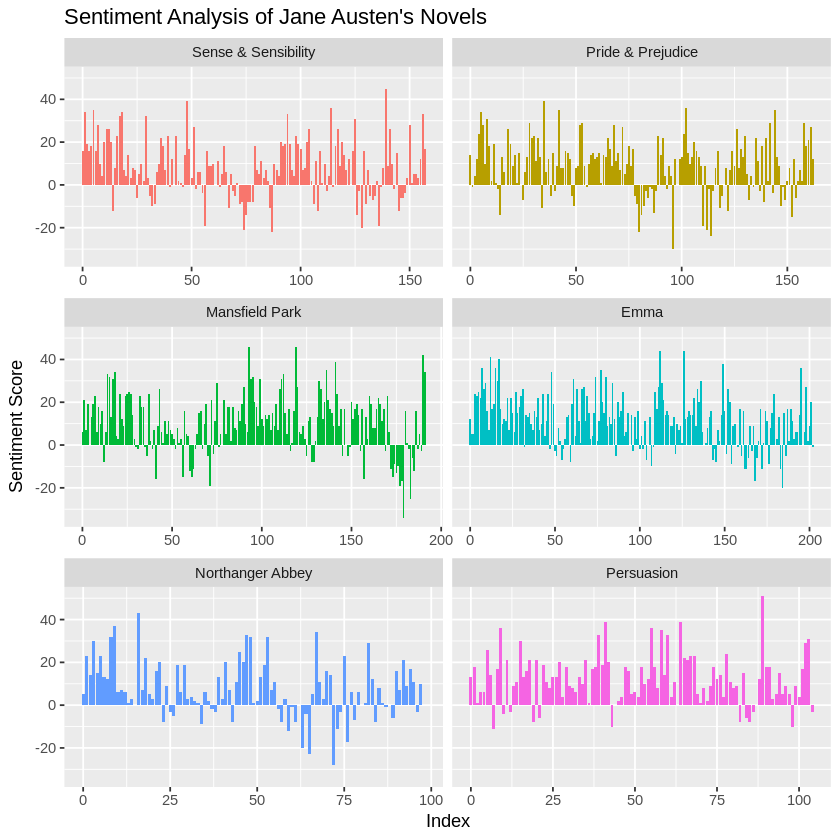

In [30]:
# Plotting sentiment over the index (line number/80) in each book
ggplot(jane_austen_sentiment, aes(index, sentiment, fill = book)) + geom_col(show.legend = FALSE) +
  facet_wrap(~book, ncol = 2, scales = "free_x") +
  labs(title = "Sentiment Analysis of Jane Austen's Novels",
       x = "Index",
       y = "Sentiment Score")

### 1.4 Finding the "Shape" of a Book

In the following cells we will work towards creating a visualization fo the sentiment in a text. We can also calculate a "mean" sentiment analysis for a text as a whole as an explorative measurement. For that, we need to pull all of the text together into a single string. The following code does so for the six books in the janeaustenr package.

In [31]:
# Loop through text from the janeaustenr package for sentiment analysis
books <- unique(austen_books()$book)

for (book_name in books) {
  book_text <- austen_books() %>%
    filter(book == book_name) %>%
    pull(text) %>%
    paste(collapse = " ") # Combine all text into a single string

  book_sentiments <- get_sentiment(get_sentences(book_text))

  cat("Mean Sentiment for", book_name, ":", mean(book_sentiments), "\n")
}

Mean Sentiment for Sense & Sensibility : 0.5119063 
Mean Sentiment for Pride & Prejudice : 0.4692573 
Mean Sentiment for Mansfield Park : 0.5333212 
Mean Sentiment for Emma : 0.5399254 
Mean Sentiment for Northanger Abbey : 0.4541713 
Mean Sentiment for Persuasion : 0.53161 


**Small Side Quest**: So far we have been using text from a package, what happens when we want to use our own corpus? In the following cell, we pull the text from Project Gutenberg's website. Go ahead and compare the mean sentiment values. This difference illustrates a need to clean and prepare texts that we get directly off the internet. We will not cover this here, but feel free to look at "Text Analysis with R for Students of Literature" (second edition) for some insight on cleaning texts from the web

In [ ]:
# Use this next line to clear the environment if you are on RStudio
# rm(list = ls())

# Get the text for Sense & Sensbility directly from Project Gutenberg
url <- "https://www.gutenberg.org/cache/epub/161/pg161.txt"
sense_v <- readLines(url, warn = FALSE) %>% paste(collapse = " ")

# Get sentiment values for the entire text
sense_sentences_v <- get_sentences(sense_v)

# View the first few sentences to confirm extraction
sense_sentences_v[1:3]

# Perform sentiment analysis on each sentence
sense_sentiments_v <- get_sentiment(sense_sentences_v)

# Calculate and print the average sentiment
mean_sentiment <- mean(sense_sentiments_v)
print(mean_sentiment)

Since we want to create an overall "shape" or curve that represents each novel, we will apply a smoothing technique to better visualize the changes in emotion over time in a novel. Remember our last graphs? Those are very informative, but they are full of peaks, chasms, and valleys. We want a smaoth like from beginning to end. For that, we will use a Discrete Cosine Transform (DCT); let's see it in action:

In [ ]:
# Normalize the sentiment scores, we will use the sentiment analysis saved as "sense_sentiments_v" in the previous code
normed_sense_shape <- get_dct_transform(
sense_sentiments_v,
x_reverse_len = 100,
scale_range = TRUE)

# Create a plot
plot(normed_sense_shape,
type="l",
col="blue",
xlab="Narrative Time",
ylab="Emotional Valence",
main = "Sense and Sensibility with DCT Smoothing and Time Normalization")


We can add other texts to our plot to be able to compare their overall "shapes" as it relates to the overall sentiment of the text over time. Since not all books are the same lenght, we "normalize" them to make each curve start and end at the same time without loosing any information from the text. For this step, let's go back to using the texts in the janeaustenr library

In [ ]:
# Define a list of selected Jane Austen novels to plot
selected_books <- c("Pride & Prejudice", "Emma", "Sense & Sensibility")

# Set up colors for each novel in the plot
colors <- c("blue", "red", "green")
color_index <- 1

# Initialize an empty plot
plot(NULL, type = "n", xlim = c(1, 100), ylim = c(-1, 1),
     xlab = "Narrative Time", ylab = "Emotional Valence",
     main = "Selected Jane Austen Novels with DCT Smoothing and Time Normalization")

# Loop through each selected book, calculate DCT-transformed sentiment, and add to the plot
for (book_name in selected_books) {
  # Extract and process the text for the current book
  book_text <- austen_books() %>%
    filter(book == book_name) %>%
    pull(text) %>%
    paste(collapse = " ")

  # Get sentences and sentiment for the book
  book_sentences <- get_sentences(book_text)
  book_sentiments <- get_sentiment(book_sentences)

  # Apply DCT transform to normalize sentiment across narrative time
  normed_shape <- get_dct_transform(book_sentiments, x_reverse_len = 100, scale_range = TRUE)

  # Add the DCT-transformed sentiment to the plot with a unique color
  lines(normed_shape, type = "l", col = colors[color_index], lwd = 1.5)
  text(x = 100, y = normed_shape[100], labels = book_name, pos = 4, col = colors[color_index])

  # Update color for the next novel
  color_index <- color_index %% length(colors) + 1
}

# Add a legend for the selected novels
legend("topright", legend = selected_books, col = colors, lty = 1, cex = 0.8)


#2.0 A Brief Intro to Topic Modeling: Clustering Texts by Theme

This example will give you a good idea of the mechanics of topic modeling with LDA, and how it uses text as data to find common themes in our text corpora. We will make it easy for our topic modeling algorithm by presenting it with a group of words from four very different books. Ideally, we should be able to "reconstruct" the books from eahc one of the topics we identify.

In practice, you might actually want to parse a corpus of very similar documents (e.g., speeches given at the United Nations, several books by the same author, poems written in the same historical period, etc); you would follow much the same process detailed here. We rely heavily on Chapter 6 of  "[Text Mining with R](https://www.tidytextmining.com/)" and Chapter 17 of "Text Analysis with R for Students of Literature" (second edition), be sure to check them out.

##2.1 Loading and preparing the text

In this step we wil load four texts from our "gutenbergr" library. Notice that our titles are very different in content. We then put each line of text froma all four novels into a table.

In [ ]:
# Pulling some titles from Project Gutenberg
# These texts are clearly different, this will help us understand how LDA works

# We define a "titles" variable to inlude our books
titles <- c("The Mysterious Island", "Emma", "The King of Elfland's Daughter", "The War of the Worlds")

# We will create a table with thre columns, each line of text will become a row
books <- gutenberg_works(title %in% titles) %>%
  gutenberg_download(meta_fields = "title")

print(books)

#Feel free to expriment here and add more literature, e.g., try , "War and Peace"

## 2.2 Text preprocessing
Here we preprocess the text for LDA Topic Modeling. We start by (1) dividing our text into "Chapters", (2) tokenizing the text into words, (3) counting word occurrences by document, and (4) excluding common "stop words" from our text to focus on meaningful words.

These are common first steps used in text mining for analyses like topic modeling. We will print a table with our resulting words so we can inspect them. Notice how we removed empty spaces, and all worrds are now in lowercase.

In [ ]:
# divide into documents, each representing one chapter
by_chapter <- books %>%
  group_by(title) %>%
  mutate(chapter = cumsum(str_detect(
    text, regex("^chapter ", ignore_case = TRUE)
  ))) %>%
  ungroup() %>%
  filter(chapter > 0) %>%
  unite(document, title, chapter)

# Spplit into words
by_chapter_word <- by_chapter %>%
  unnest_tokens(word, text)

# Calculate document-word counts
word_counts <- by_chapter_word %>%
  anti_join(stop_words) %>%          # This line removes common words (like "the," "and") to focus on meaningful content.
  count(document, word, sort = TRUE)

print(word_counts)

##2.3 Creating a Document-Term Matrix
To run topic modeling, we need our text data to become a numerical input. A Document-Term Matrix (DTM) provides this by counting the frequency of each word in each document, converting qualitative text into quantitative data.

The DTM makes it possible for our program to analyze how often certain words appear in different documents. This "frequency" information is crucial for identifying which words are contributing to specific topics. This next step creates a DTM from the chapter-wise word counts we created previously, to set up our data for topic modeling.

In [ ]:
# Create a DTM from our "word_counts" variable
chapters_dtm <- word_counts %>%
  cast_dtm(document, word, n)

print(chapters_dtm)

##2.4 Applying Topic Modeling with Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA)

We will now use Latent Dirichlet Allocation (LDA) to extract topics from DTM we created! The LDA function allows us to specify the number of topics (k) we want to extract from the data. In this example, we will set k=4 as a way to demonstrate how topic modeling with LDA works. In practice, however, you will iterate k based on your experiential knowledge of the corpus, so you may find more or less topics depending on your project.


 As a secondary step, we will identify the top terms associated with each topic, and displays these results. This can help us analyze and understand the emerging theme in each topic.  

In [ ]:
# Fitting an LDA topic model with 4 topics
chapters_lda <- LDA(chapters_dtm, k = 4, control = list(seed = 1234))

# Extract the topic-word probabilities (beta values) to identify top terms
# These beta values represent the association strength between each word and the identified topics
chapter_topics <- tidy(chapters_lda, matrix = "beta")

# Create a table with the six "top terms" for each of the topics identified by our LDA
top_terms <- chapter_topics %>%
  group_by(topic) %>%
  slice_max(beta, n = 6) %>% # "n" sets the number of top words we want to see, try changing the value of "n" to explore more words
  ungroup() %>%
  arrange(topic, -beta)

print(top_terms)

So we already ran our topic modeling, and asked our program to divide the themes it found across the "bag of words" into four groups. To better visualize this, let's create a plot that shows the rgouopf of top words in each "topic". Once you run the visualization, look at the four topics. Was our program succesful in "reconstructing" the themes in the novels?

In [ ]:
# Vizualizing the topic models
top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  scale_y_reordered()

##Thank you for making it this far, we hope you enjoyed this short intro to Sentiment Analysis and Topic Modeling!